In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from scipy import stats

In [84]:
df = pd.read_excel("DATA.xlsx")
df.head(10)

,Date,Class Level,Time Spent
0,2022-10-24,Upper,2.226844
1,2022-10-24,Lower,0.085916
2,2022-10-24,Lower,2.455181
3,2022-10-24,Upper,0.219084
4,2022-10-24,Lower,0.623450
5,2022-10-24,Upper,0.887241
6,2022-10-24,Lower,1.469291
7,2022-10-24,Upper,0.340358
8,2022-10-24,Upper,0.422612
9,2022-10-24,Lower,1.160892


In [85]:
Time_min = round(df['Time Spent'] * 60, 2)
Time_min

0      133.61
1        5.15
2      147.31
3       13.15
4       37.41
        ...  
546    146.68
547    138.11
548      5.06
549    133.46
550     68.52
Name: Time Spent, Length: 551, dtype: float64

In [86]:
df['Time_min'] = Time_min
df.head(10)

,Date,Class Level,Time Spent,Time_min
0,2022-10-24,Upper,2.226844,133.61
1,2022-10-24,Lower,0.085916,5.15
2,2022-10-24,Lower,2.455181,147.31
3,2022-10-24,Upper,0.219084,13.15
4,2022-10-24,Lower,0.623450,37.41
5,2022-10-24,Upper,0.887241,53.23
6,2022-10-24,Lower,1.469291,88.16
7,2022-10-24,Upper,0.340358,20.42
8,2022-10-24,Upper,0.422612,25.36
9,2022-10-24,Lower,1.160892,69.65


In [87]:
df['Time_min']

0      133.61
1        5.15
2      147.31
3       13.15
4       37.41
        ...  
546    146.68
547    138.11
548      5.06
549    133.46
550     68.52
Name: Time_min, Length: 551, dtype: float64

In [104]:
mean_upper = df.loc[(df['Class Level'] == 'Upper')]
mean_upper_mean = mean_upper['Time_min'].mean()
mean_upper_mean

73.87085034013604

In [105]:
mean_lower = df.loc[(df['Class Level'] == 'Lower')]
mean_lower_mean = mean_lower['Time_min'].mean()
mean_lower_mean

78.40089494163423

# Exploratory Data Analysis (EDA)

In [154]:
students = df.groupby('Class Level')['Class Level'].count()
students

Class Level
Lower    257
Upper    294
Name: Class Level, dtype: int64

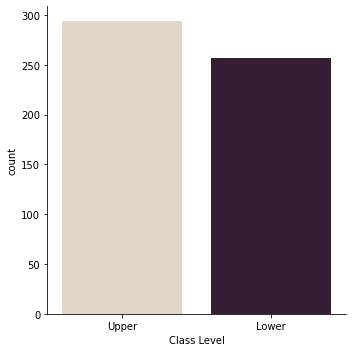

In [88]:
sns.catplot(data=df, x="Class Level", kind="count", palette="ch:.25")

<AxesSubplot:xlabel='Date'>

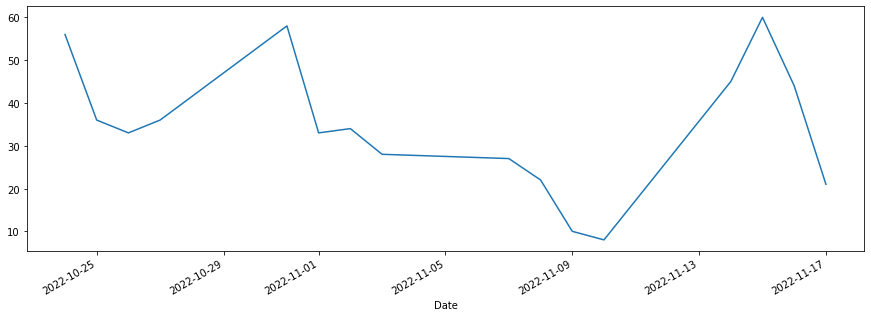

In [89]:
data = df.groupby('Date')['Class Level'].count()
#data = data.set_index('Date')
data.plot(figsize=(15,5))

In [90]:
data

Date
2022-10-24    56
2022-10-25    36
2022-10-26    33
2022-10-27    36
2022-10-31    58
2022-11-01    33
2022-11-02    34
2022-11-03    28
2022-11-07    27
2022-11-08    22
2022-11-09    10
2022-11-10     8
2022-11-14    45
2022-11-15    60
2022-11-16    44
2022-11-17    21
Name: Class Level, dtype: int64

In [91]:
mu = data.mean()
mu

34.4375

# Poisson Distribution to model the number of students

In [92]:
from scipy.stats import poisson

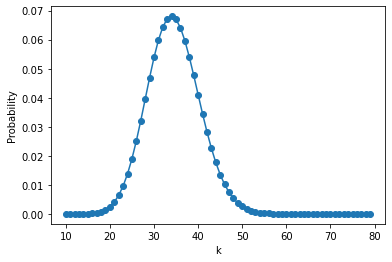

In [93]:
k = np.arange(10, 80)
pmf = poisson.pmf(k, mu=mu)

plt.plot(k, pmf, marker='o')
plt.xlabel('k')
plt.ylabel('Probability')
plt.show()

# Exponential Distribution to model the time spent

In [94]:
from scipy.stats import expon

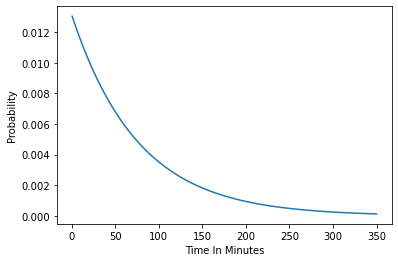

In [111]:
mean = df['Time_min'].mean()

loc = 0

xvalues = np.linspace(stats.expon.ppf(0.01, loc, mean), stats.expon.ppf(0.99, loc, mean), 100)
pdf = expon.pdf(xvalues, loc, mean)
plt.plot(xvalues, pdf)
plt.xlabel('Time In Minutes')
plt.ylabel('Probability')
plt.show()

In [112]:
mean

75.98377495462786

# Simulation

Mean Upper Queue Wait Time:  0.040149651448587065
Mean lower Queue Wait Time:  31.99460380309825
Mean registration Queue Wait Time:  0.03973899787176859


(array([47.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.19271833, 0.38543665, 0.57815498, 0.77087331,
        0.96359163, 1.15630996, 1.34902829, 1.54174662, 1.73446494,
        1.92718327]),
 <BarContainer object of 10 artists>)

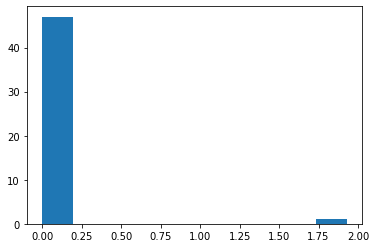

In [150]:
import matplotlib.pyplot as plt
import simpy
import random
from statistics import mean
import numpy as np

#the below generator function brings our students into being
def student_generator_tutoring(env, tut_inter, mean_reg, mean_session, mean_upper_session, receptionist, upper_tutor, lower_tutor):
    tu_id = 0
    
    while True:
        wp = activity_generator_tutoring(env, mean_reg, mean_session, mean_upper_session, receptionist, upper_tutor, lower_tutor, tu_id)
        #pass wp to the process of tutoring, defined below
        env.process(wp)
        #sampling t, time until next students, from exponential distr, lambda = 1/mean
        t = random.expovariate(1.0/ tut_inter)
        #freeze the process until t time has pased
        yield env.timeout(t)
        #create next students and then restart while loop
        tu_id += 1
#the below generator function 'describes/defines' the process by which students will be tutored
#they first register with the 'receptionist', and then attend a tutoring session with either an upper level tutor, or lower level tutor,
def activity_generator_tutoring(env, mean_reg, mean_session, mean_upper_session, receptionist, upper_tutor, lower_tutor, tu_id):
    #recording time students enters the queue
    global list_of_registration_queues
    global list_of_lower_queues
    global list_of_upper_queues
    time_entered_queue_for_registration = env.now
    #now print 'student __ entered queue at ___ time'
    # print("student ", tu_id, " entered  reg queue at ", time_entered_queue_for_registration, sep="")
    with receptionist.request() as req:
        yield req #wait until tutor is avaliable
        time_left_queue_for_registration = env.now
        # print("student ", tu_id , "left reg queue  at ", time_left_queue_for_registration, " minutes", sep="") 
        time_in_queue_for_registration = (time_left_queue_for_registration - time_entered_queue_for_registration)
        list_of_registration_queues.append(time_in_queue_for_registration)
        # print("student " , tu_id, "queued in reg for ", time_in_queue_for_registration, " minutes!!!", sep= "" )
        sampled_registration_time = random.expovariate(1.0 / mean_reg)
        yield env.timeout(sampled_registration_time) 
    #request tutor from simpy env
    decide_class = random.uniform(0,1)
    if decide_class < 0.65:
        time_entered_queue_for_lower_tutor = env.now
        with lower_tutor.request() as req:
            yield req #wait until tutor is avaliable
            time_left_queue_for_lower_tutor = env.now
            # print("student", tu_id, "left queue at ", time_left_queue_for_lower_tutor, sep = "")
            time_in_queue_for_lower_tutor = (time_left_queue_for_lower_tutor - time_entered_queue_for_lower_tutor)
            # print("student " , tu_id, "queued for LOWER tutor for ", time_in_queue_for_lower_tutor, " minutes. !!!", sep= "" )
            list_of_lower_queues.append(time_in_queue_for_lower_tutor)
            sampled_session_time = random.expovariate(1.0 / mean_session)
            yield env.timeout(sampled_session_time) #this freezes the with statement whilst the tutor is busy with a student
    else:
        time_entered_queue_for_upper_tutor = env.now
        with upper_tutor.request() as req1:
            yield req1 #wait until tutor is avaliable
            time_left_queue_for_upper_tutor = env.now
            # print("student", tu_id, "left queue at ", time_left_queue_for_upper_tutor, sep = "")
            time_in_queue_for_upper_tutor = (time_left_queue_for_upper_tutor - time_entered_queue_for_upper_tutor)
            # print("student " , tu_id, "queued for UPPER tutor for ", time_in_queue_for_upper_tutor, " minutes. !!!", sep= "" )
            list_of_upper_queues.append(time_in_queue_for_upper_tutor)
            sampled_upper_session_time = random.expovariate(1.0 / mean_upper_session)
            yield env.timeout(sampled_upper_session_time) #this freezes the with statement whilst the tutor is busy with a student
#set up simulation envrionment - env
env = simpy.Environment()
lower_tutor = simpy.Resource(env, capacity = 4)
upper_tutor = simpy.Resource(env, capacity = 1)
receptionist = simpy.Resource(env, capacity = 1)

mean_reg = 2
tut_inter = 76
mean_session = mean_lower_mean
mean_upper_session = mean_upper_mean
#mean_reg is mean time that registration takes ... currently 1 minute
#mean_session is the mean time that a tutoring session takes, currently 29 minutes, a single tutor can handle 2 students
#tut_inter is the mean time interval that students enter the tutoring center
list_of_registration_queues = []
list_of_upper_queues = []
list_of_lower_queues = []

env.process(student_generator_tutoring(env, tut_inter, mean_reg, mean_session, mean_upper_session, receptionist, lower_tutor, upper_tutor))     
env.run(until=10000)

mean_upper_q = mean(list_of_upper_queues)
mean_reg_q = mean(list_of_registration_queues)
mean_lower_q = mean(list_of_lower_queues)

print("Mean Upper Queue Wait Time: " , mean_upper_q)
print("Mean lower Queue Wait Time: " , mean_lower_q)
print("Mean registration Queue Wait Time: " , mean_reg_q)

plt.hist(list_of_upper_queues)

(array([131.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.41817392, 0.83634784, 1.25452176, 1.67269569,
        2.09086961, 2.50904353, 2.92721745, 3.34539137, 3.76356529,
        4.18173921]),
 <BarContainer object of 10 artists>)

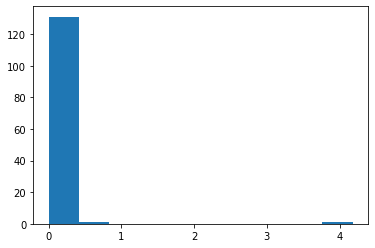

In [151]:
plt.hist(list_of_registration_queues)

(array([54.,  8., 10.,  7.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([  0.        ,  31.88808609,  63.77617218,  95.66425826,
        127.55234435, 159.44043044, 191.32851653, 223.21660261,
        255.1046887 , 286.99277479, 318.88086088]),
 <BarContainer object of 10 artists>)

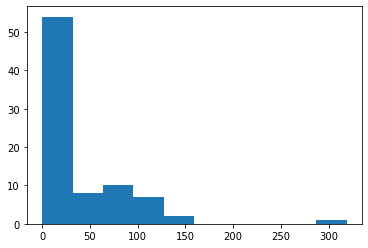

In [152]:
plt.hist(list_of_lower_queues)